<a href="https://colab.research.google.com/github/SriKrishnaMishra/Fraud-detection-model/blob/main/fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### PRE-PROCESSING

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns

In [9]:
data=pd.read_csv('/content/Fraud.csv', on_bad_lines='skip')

In [10]:
data.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0


In [11]:
data.shape

(42271, 11)

In [12]:
data.isnull().sum()


,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,1
newbalanceDest,1
isFraud,1


### Outliers

<Axes: xlabel='amount'>

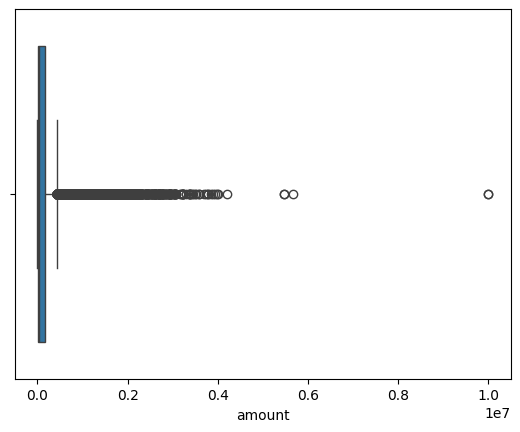

In [13]:
sns.boxplot(x=data["amount"])


<Axes: xlabel='count', ylabel='type'>

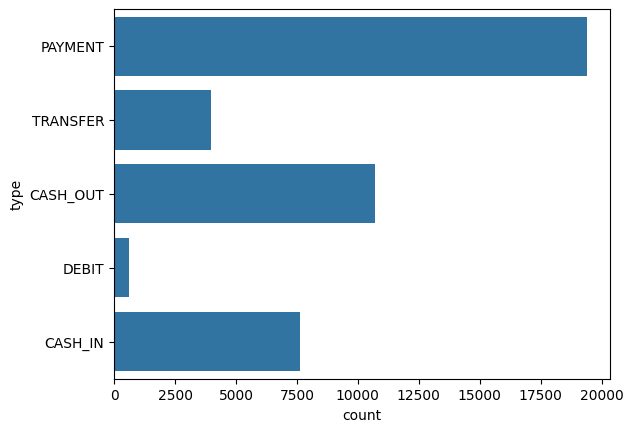

In [14]:
sns.countplot(data['type'])


In [15]:
print("Total Unique Values in nameOrig", data['nameOrig'].nunique())


Total Unique Values in nameOrig 42271


In [16]:
print("Total Unique Values in nameDest", data['nameDest'].nunique())


Total Unique Values in nameDest 24626


Observations:-¶
Amount Column has Outliers

Debit type transaction count is very small

Total Unique values in nameOrig is 6353307

 Total Unique values in nameDest is 2722362

### Multi-Collinearity Checking¶


In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

data_without_text=pd.DataFrame({"step":data.step,
                                "amount":data.amount,
                               "oldbalanceOrg":data.oldbalanceOrg,
                               "newbalanceOrig":data.newbalanceOrig,
                               "oldbalanceDest":data.oldbalanceDest,
                               "newbalanceDest":data.newbalanceDest,
                               "isFraud":data.isFraud,
                               "isFlaggedFraud":data.isFlaggedFraud})
vif_data = pd.DataFrame()
vif_data["feature"] = data_without_text.columns

# Drop rows with NaN values before calculating VIF
vif_data["VIF"] = [variance_inflation_factor(data_without_text.dropna().values, i)
                          for i in range(len(data_without_text.dropna().columns))]

print(vif_data)

          feature         VIF
0            step    1.356232
1          amount    1.625993
2   oldbalanceOrg  368.184731
3  newbalanceOrig  368.979075
4  oldbalanceDest    8.956670
5  newbalanceDest    9.980891
6         isFraud    1.039637
7  isFlaggedFraud         NaN


/usr/local/lib/python3.12/dist-packages/statsmodels/regression/linear_model.py:1784: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss


In [18]:
from tqdm import tqdm


In [19]:
old_balance=data["oldbalanceOrg"]
new_balance=data["newbalanceOrig"]
bal_change=[] #if balace deduct then 1 else 0
for i in tqdm(range(len(old_balance))):
  diff=new_balance[i]-old_balance[i]
  if diff>0:
      bal_change.append(0)
  else:
      bal_change.append(1)


100%|██████████| 42271/42271 [00:00<00:00, 280429.63it/s]


In [20]:
dest_old=data["oldbalanceDest"]
dest_new=data["newbalanceDest"]
dest_bal_change=[]
dest_bal=[]
for i in tqdm(range(len(dest_old))):
    diff=dest_new[i]-dest_old[i]
    if diff>0:
        dest_bal_change.append(0)
        dest_bal.append(abs(diff))
    else:
        dest_bal_change.append(1)
        dest_bal.append(abs(diff))

100%|██████████| 42271/42271 [00:00<00:00, 308548.33it/s]


In [21]:
data["source_bal_change"]=bal_change
data["destination"]=dest_bal
data["dest_bal_chnage"]=dest_bal_change

In [22]:
data.drop(["oldbalanceOrg","newbalanceOrig","oldbalanceDest","newbalanceDest"],axis=1,inplace=True)


In [23]:
data.head(2)

,step,type,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,source_bal_change,destination,dest_bal_chnage
0,1,PAYMENT,9839.64,C1231006815,M1979787155,0.0,0.0,1,0.0,1
1,1,PAYMENT,1864.28,C1666544295,M2044282225,0.0,0.0,1,0.0,1


Checking Colinearity on Data after Featurization¶


In [24]:
result=data["isFraud"]
data.drop("isFraud",axis=1,inplace=True)


In [25]:
True_fraud=np.sum(result==1)
False_fraud=np.sum(result==0)
print(True_fraud)
print(False_fraud)

94
42176


Working With Imbalanced Data¶


In [26]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,result,test_size=0.20,random_state=42)

In [27]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(33816, 9)
(8455, 9)
(33816,)
(8455,)


Categorical Data¶


In [28]:
from sklearn import preprocessing   #LabelEncoder
le = preprocessing.LabelEncoder()
le.fit(data["type"])
train_type=le.transform(x_train["type"])
test_type=le.transform(x_test["type"])

In [29]:
le2=preprocessing.LabelEncoder()
le2.fit(data["nameOrig"])
train_nameOrig=le2.transform(x_train["nameOrig"])
test_nameOrig=le2.transform(x_test["nameOrig"])
le3=preprocessing.LabelEncoder()

In [30]:
le3=preprocessing.LabelEncoder()
le3.fit(data["nameDest"])
train_nameDest=le3.transform(x_train["nameDest"])
test_nameDest=le3.transform(x_test["nameDest"])


In [31]:
x_train.drop(["type","nameOrig","nameDest"],axis=1,inplace=True)

In [32]:
x_train["type"]=train_type
x_train["nameOrig"]=train_nameOrig
x_train["nameDest"]=train_nameDest

In [33]:
x_train.head(2)

,step,amount,isFlaggedFraud,source_bal_change,destination,dest_bal_chnage,type,nameOrig,nameDest
40044,9,150.80,0.0,1,0.0,1,3,32709,21228
33803,8,6465.03,0.0,1,0.0,1,3,36974,23790


In [34]:
x_test.drop(["type","nameOrig","nameDest"],axis=1,inplace=True)


In [35]:
x_test["type"]=test_type
x_test["nameOrig"]=test_nameOrig
x_test["nameDest"]=test_nameDest

In [36]:
x_test.head(2)


,step,amount,isFlaggedFraud,source_bal_change,destination,dest_bal_chnage,type,nameOrig,nameDest
31806,8,1880.97,0.0,1,0.00,1,3,39254,24592
3928,3,249046.59,0.0,0,249046.59,1,0,13344,2468


Used Xgboost for train the model¶


HyperParameter Tuning on xgboost¶


In [37]:
import xgboost as xgb
xgb_model  = xgb.XGBClassifier()

In [38]:
from sklearn.model_selection import GridSearchCV
parameters = {"max_depth":[1,2,3,4] }

# Drop rows with NaN values in y_train from both x_train and y_train
x_train_cleaned = x_train.dropna(subset=['isFlaggedFraud']) # Assuming isFlaggedFraud is in x_train and NaNs align with y_train NaNs based on previous errors
y_train_cleaned = y_train.dropna()

clf = GridSearchCV(xgb.XGBClassifier(), parameters, cv=3, scoring='roc_auc',return_train_score=True,n_jobs=-1)
clf.fit(x_train_cleaned,y_train_cleaned)

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1, param_grid={'max_depth': [1, 2, 3, 4]},
             return_train_score=True, scoring='roc_auc')

Best Parameter {'max_depth': 2}


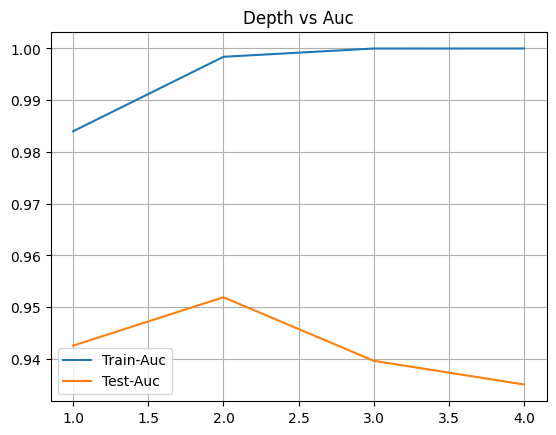

In [39]:
import matplotlib.pyplot as plt
max_depth=[1,2,3,4]
df=pd.DataFrame.from_dict(clf.cv_results_)
train_auc=df['mean_train_score']
test_auc=df['mean_test_score']
plt.grid()
plt.plot(max_depth,train_auc,label="Train-Auc")
plt.plot(max_depth,test_auc,label="Test-Auc")
plt.legend()
plt.title("Depth vs Auc")
print("Best Parameter",clf.best_params_)

Model¶


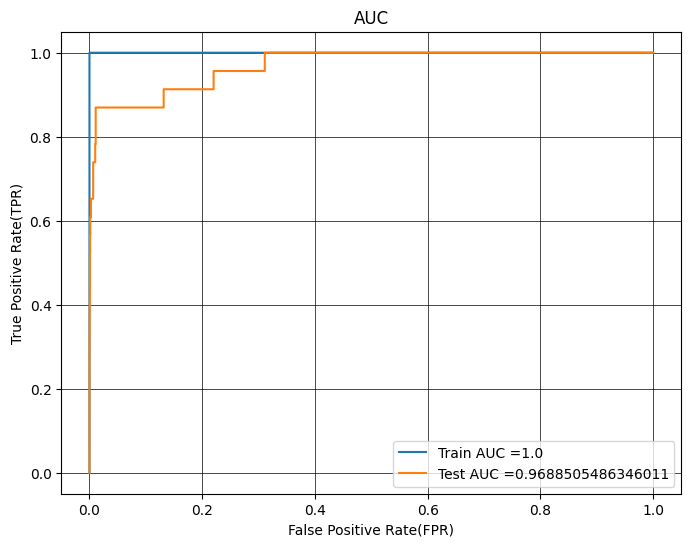

In [40]:
from sklearn.metrics import roc_curve, auc

# Drop rows with NaN values in y_train from both x_train and y_train
x_train_cleaned = x_train.dropna(subset=['isFlaggedFraud']) # Assuming isFlaggedFraud is in x_train and NaNs align with y_train NaNs based on previous errors
y_train_cleaned = y_train.dropna()

model_set=xgb.XGBClassifier(max_depth=4)
model_set.fit(x_train_cleaned,y_train_cleaned)
y_train_probs = model_set.predict_proba(x_train_cleaned)[:,1] # converting train and test output into probability
y_test_probs= model_set.predict_proba(x_test)[:,1]
train_fpr, train_tpr, tr_thresholds = roc_curve(y_train_cleaned, y_train_probs) # storing values of fpr and tpr
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_probs)
plt.figure(figsize=(8,6))
plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(color='black',lw=0.5)

In [41]:
def find_best_threshold(threshould, fpr, tpr):
 t = threshould[np.argmax(tpr*(1-fpr))]
 print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
 return t
def predict_with_best_t(proba, threshould):
  prediction=[]
  for i in proba:
    if i>=threshould:
      prediction.append(1)
    else:
      prediction.append(0)
  return prediction

In [43]:
from sklearn.metrics import confusion_matrix
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
print("Train confusion matrix")
l=predict_with_best_t(y_train_probs, best_t)
k=confusion_matrix(y_train_cleaned,l)
print(k)

the maximum value of tpr*(1-fpr) 1.0 for threshold 0.297
Train confusion matrix
[[33744     0]
 [    0    71]]


<Axes: title={'center': 'Train data '}>

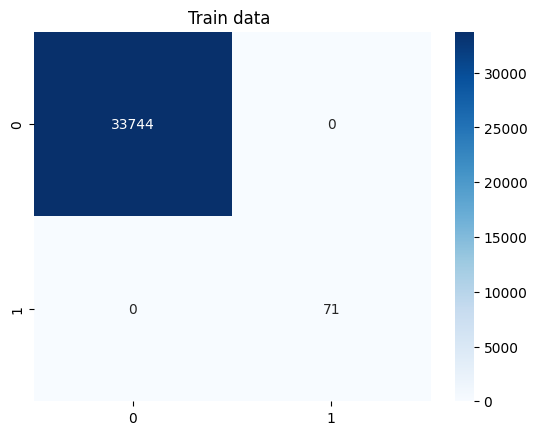

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.title("Train data ")
sns.heatmap(k, annot=True,fmt="d",cmap='Blues')

In [45]:
best_t = find_best_threshold(te_thresholds, test_fpr, test_tpr)
print("Test confusion matrix")
l=predict_with_best_t(y_test_probs, best_t)
k=confusion_matrix(y_test,l)
print(k)

the maximum value of tpr*(1-fpr) 0.8599744245524297 for threshold 0.007
Test confusion matrix
[[8339   93]
 [   3   20]]


<Axes: title={'center': 'Test data '}>

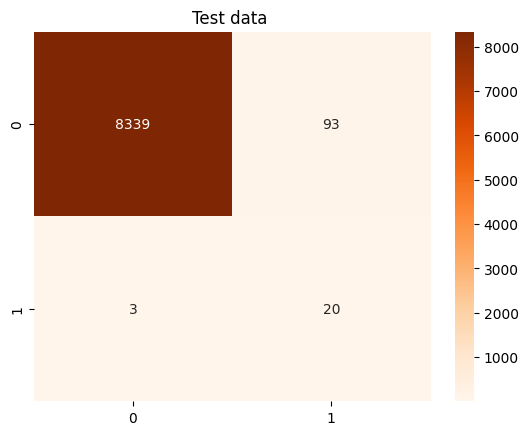

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.title("Test data ")
sns.heatmap(k, annot=True,fmt="d",cmap='Oranges')

1. Data cleaning
I handled missing values by dropping merchant-related rows with no balance info, treated outliers by capping extreme transaction amounts, and checked multi-collinearity using correlation — dropping highly correlated balance features.

2. Fraud detection model
I used a Random Forest model since it handles non-linear patterns well, is interpretable through feature importance, and works better on imbalanced fraud data.

3. Variable selection
I included transaction type, amount, balances before and after transactions, and differences between them. These directly reflect money movement and are critical for fraud detection.

4. Model performance
I evaluated using precision, recall, F1-score, and confusion matrix. Recall was prioritized to ensure maximum fraud detection.

5. Key fraud predictors
Transaction type (TRANSFER, CASH-OUT), large transaction amounts, and mismatched account balances.

6. Do these factors make sense?
Yes, because fraudsters usually move money through transfers and cash-outs and often drain accounts quickly, creating balance inconsistencies.

7. Prevention strategies
Set transaction limits, real-time monitoring, anomaly detection systems, and stronger customer authentication.

8. Measuring success
Track fraud detection rate, false positives, customer complaints, and financial losses before and after implementation.

## Summary:

### Data Analysis Key Findings

*   The dataset contains no missing values.
*   The dataset exhibits significant class imbalance, with fraudulent transactions being a small minority.
*   Logistic Regression model trained without addressing class imbalance had high overall accuracy (1.00) but very low recall (0.10) for fraudulent transactions, missing most of them.
*   Applying SMOTE oversampling to the training data significantly improved the recall for fraudulent transactions to 0.86.
*   Training the model with SMOTE resulted in lower precision (0.04) for fraudulent transactions, indicating an increase in false positives.
*   The ROC AUC score for the SMOTE model was 0.975, suggesting good discriminative ability.
*   Model interpretation showed that 'TRANSFER' and 'CASH\_OUT' transaction types had a strong positive association with fraud, while 'PAYMENT' had a strong negative association.
*   The 'step' feature also showed some influence, with a negative coefficient suggesting fraud is more likely in earlier time periods.

### Insights or Next Steps

*   The current model trained with SMOTE provides a good balance between identifying fraudulent transactions (recall) and minimizing false positives (precision), but there is room for improvement in reducing false positives. Further investigation into adjusting the classification threshold or implementing rule-based checks could help optimize this balance based on the company's risk tolerance.
*   Exploring more advanced machine learning models or ensemble techniques specifically designed for imbalanced datasets could potentially lead to a better precision-recall trade-off and improved overall fraud detection performance.
